## Generative models should preserve relative distances from input to latent to generated space
- Read in model and some n input images
- Using L1 (others later), find distance between image pairs
- Transform to latent space and output space, again measuring L1 at both stages
- Do analysis

In [22]:
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning
from pytorch_lightning import Trainer
from dataloader import Dataset
import os
import vae
from model import Model
import simplejson 
import matplotlib.pyplot as plt

In [2]:
exs = [
    '/home/sonia/generative-models/logs/dists/mnist/vae/version_0',
    '/home/sonia/generative-models/logs/dists/gtsrb/vae/version_0' 
]

In [3]:
path_to_model = exs[1]
n = 100

### Setup
#### Read in model

In [4]:
modelconfig = simplejson.load(open(os.path.join(path_to_model, 'modelconfig.json')))
dataconfig = simplejson.load(open(os.path.join(path_to_model, 'dataconfig.json')))
checkpoint = os.path.join(path_to_model, 'checkpoints/last.ckpt')

In [5]:
model = vae.vanilla_vae(**modelconfig['model_params']).cuda()
experiment = Model(model.cuda(), modelconfig['exp_params']).cuda()
e=experiment.load_from_checkpoint(checkpoint, model=model.cuda(), params=modelconfig['exp_params'])
trainer = Trainer(gpus=[0])

/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Read in data

In [6]:
data = Dataset(**dataconfig, pin_memory=True)#use GPU
data.setup()
val = data.val_dataset

In [7]:
#choose random subset of n samples
randy = torch.rand(size=(len(val), ))
indices = [i.item() for i in torch.topk(randy, n)[1]] #actual index numbers
inputdata = torch.utils.data.Subset(val, indices)
input = DataLoader(inputdata, 
                    batch_size=dataconfig['val_batch_size'],
                    num_workers=dataconfig['num_workers'],
                    shuffle=False,
                    pin_memory=True)

### Evaluate

#### (Optional) run on all train and test data to compare metrics

In [51]:
trainer.test(model=experiment, dataloaders=data.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_L1_distance        0.08025480806827545
      test_frechet           5.549494743347168
   test_inception_mean      3.6688289642333984
   test_inception_stdv      0.09418610483407974
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_L1_distance': 0.08025480806827545,
  'test_inception_mean': 3.6688289642333984,
  'test_inception_stdv': 0.09418610483407974,
  'test_frechet': 5.549494743347168}]

In [52]:
trainer.test(model=experiment, dataloaders=data.train_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_L1_distance        0.07435835897922516
      test_frechet           5.867834091186523
   test_inception_mean       3.713123321533203
   test_inception_stdv     0.028421320021152496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_L1_distance': 0.07435835897922516,
  'test_inception_mean': 3.713123321533203,
  'test_inception_stdv': 0.028421320021152496,
  'test_frechet': 5.867834091186523}]

#### Transform to latent and output spaces

In [26]:
o = []
i = []
mu = []
logvar = []
model=model.cuda()

In [27]:
for batch, x in input:
    res = model.forward(batch.cuda())
    logvar.append(res[3])
    i.append(batch)
    mu.append(res[2])
    o.append(res[0])

In [28]:
o=torch.cat(o).cpu().detach().numpy()
i=torch.cat(i).cpu().detach().numpy()
mu = torch.cat(mu).cpu().detach().numpy()
logvar = torch.cat(logvar).cpu().detach().numpy()

In [29]:
import math
var = math.e**logvar
var

array([[1.0036769 , 0.9882216 , 0.9997112 , ..., 0.98277414, 0.99088264,
        0.9941791 ],
       [0.9993825 , 0.99847525, 0.9899541 , ..., 0.9975696 , 0.9971697 ,
        0.99563533],
       [0.99944144, 0.9993798 , 0.9984516 , ..., 0.99998873, 0.9951567 ,
        0.99747276],
       ...,
       [0.9979961 , 1.0012712 , 1.0002234 , ..., 0.996782  , 0.99817777,
        0.9993471 ],
       [1.0009954 , 0.9996527 , 1.0011286 , ..., 0.9990406 , 1.0006781 ,
        1.002922  ],
       [0.9946726 , 1.005741  , 0.992503  , ..., 0.9855893 , 0.9921259 ,
        1.0016    ]], dtype=float32)

In [117]:
len(l)

2

In [118]:
l[0][0].shape

torch.Size([64, 256])

In [11]:
import math

In [74]:
mu=l[0][0].cpu().detach().numpy()[:,0]

In [85]:
logvar=l[0][1].cpu().detach().numpy()[:,0]
var=math.e**logvar

In [88]:
var

array([0.9893698 , 1.0002428 , 0.99899745, 0.9998172 , 0.98649013,
       1.0035549 , 1.0043827 , 0.99911916, 1.0057533 , 0.997098  ,
       0.9972746 , 1.0081412 , 1.0030117 , 0.9997033 , 1.0012852 ,
       0.99558944, 1.0001696 , 0.9972103 , 1.0010653 , 0.99851584,
       0.9985781 , 0.9937944 , 0.994138  , 0.9967381 , 0.9994516 ,
       0.9989438 , 0.99905246, 0.98770344, 1.0031505 , 0.99758625,
       0.9901644 , 1.0000278 , 0.9949043 , 1.0022262 , 0.9921359 ,
       0.99983764, 1.0037732 , 0.9993719 , 1.001659  , 1.003038  ,
       0.99881274, 1.0043548 , 1.0029194 , 0.99902356, 0.9947664 ,
       1.0041405 , 1.003583  , 1.0022933 , 0.996988  , 0.9941957 ,
       0.9993963 , 1.0038018 , 0.99492747, 1.0015634 , 1.000931  ,
       1.003288  , 0.9978011 , 0.99504876, 0.99863803, 0.9940046 ,
       1.0011804 , 1.0059388 , 1.0002638 , 1.0036145 ], dtype=float32)

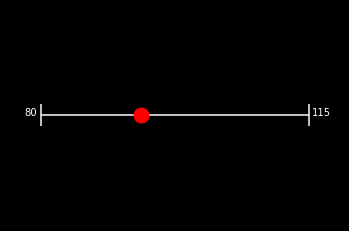

In [76]:


# set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0,10)
ax.set_ylim(0,10)

# draw lines
xmin = 1
xmax = 9
y = 5
height = 1

plt.hlines(y, xmin, xmax)
plt.vlines(xmin, y - height / 2., y + height / 2.)
plt.vlines(xmax, y - height / 2., y + height / 2.)

# draw a point on the line
px = 4
plt.plot(px,y, 'ro', ms = 15, mfc = 'r')

# add numbers
plt.text(xmin - 0.1, y, '80', horizontalalignment='right')
plt.text(xmax + 0.1, y, '115', horizontalalignment='left')

plt.axis('off')
plt.show()

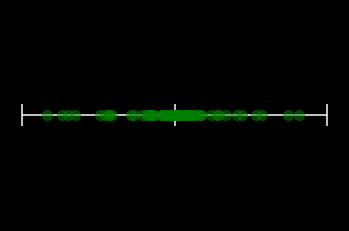

In [109]:
# set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-0.11,0.11)
ax.set_ylim(0,10)

# draw lines
xmin = -0.1
xmax = 0.1
y = 5
height = 1

plt.hlines(y, xmin, xmax)
plt.vlines(xmin, y - height / 2., y + height / 2.)
plt.vlines(0, y - height / 2., y + height / 2.)
plt.vlines(xmax, y - height / 2., y + height / 2.)

for i in range(len(mu)):
    plt.plot(mu[i], y, 'go', ms = 10*var[i], mfc = 'g', alpha=0.5)

plt.axis('off')
plt.show()

https://stackoverflow.com/questions/23186804/graph-point-on-straight-line-number-line-in-python

In [23]:
def graph(mu, var):
    # set up the figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(-0.11,0.11)
    ax.set_ylim(0,10)

    # draw lines
    xmin = -0.1
    xmax = 0.1
    y = 5
    height = 1

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(0, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)

    for i in range(len(mu)):
        plt.plot(mu[i], y, 'go', ms = 10*var[i], mfc = 'g', alpha=0.5)

    plt.axis('off')
    plt.show()

0


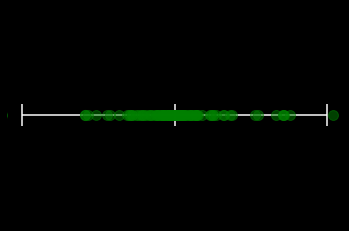

1


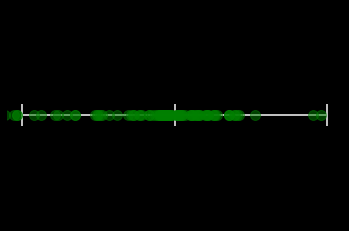

2


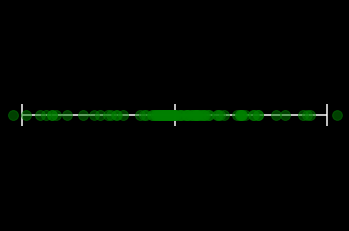

3


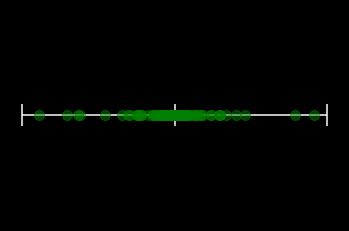

4


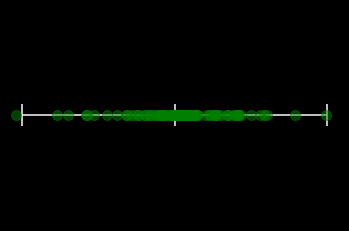

5


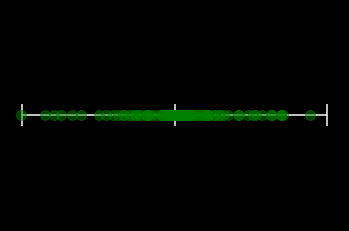

6


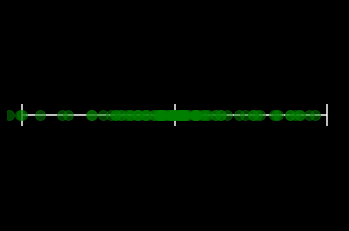

7


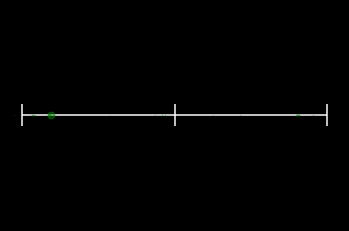

8


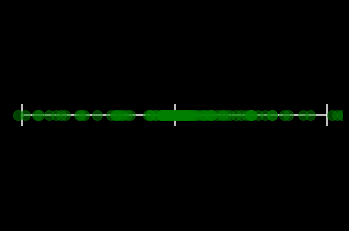

9


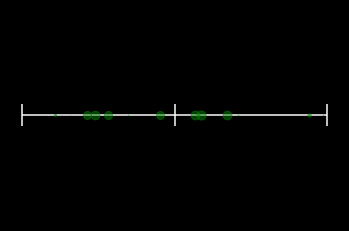

10


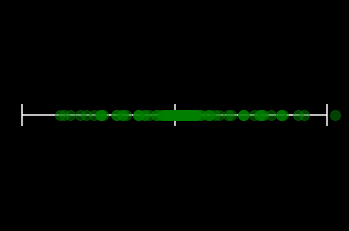

11


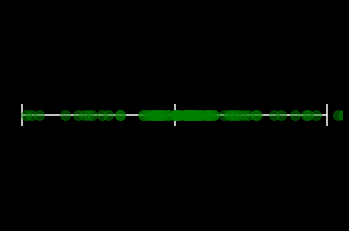

12


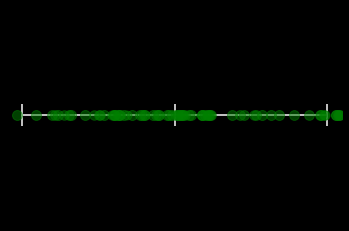

13


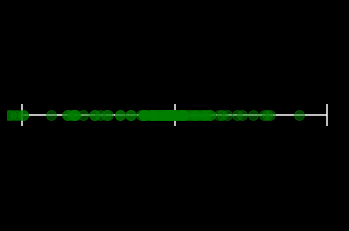

14


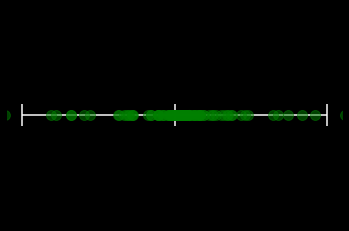

15


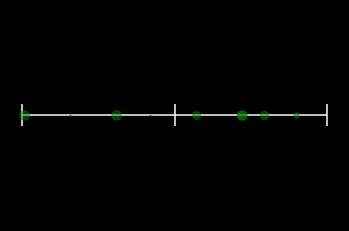

16


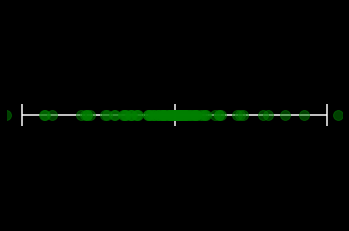

17


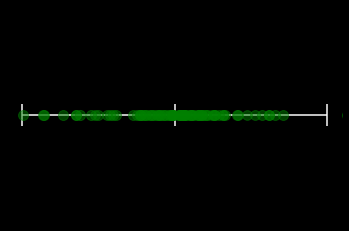

18


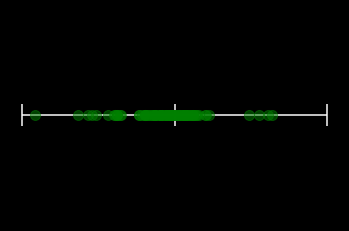

19


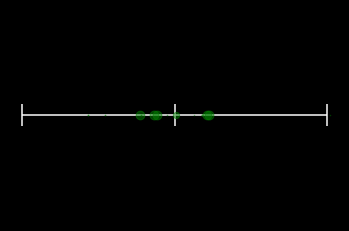

20


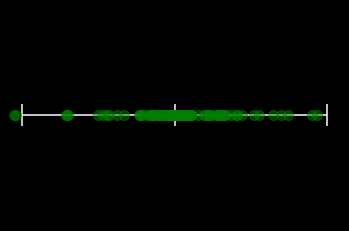

21


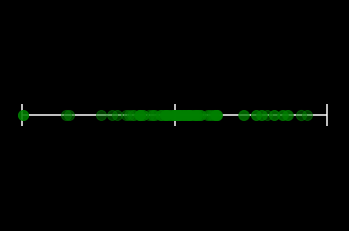

22


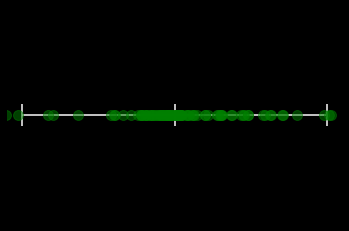

23


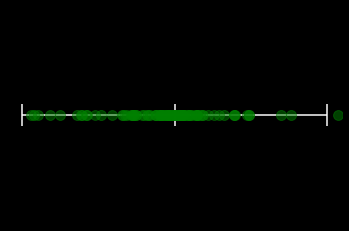

24


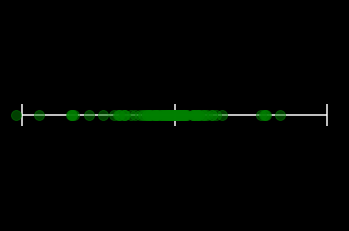

25


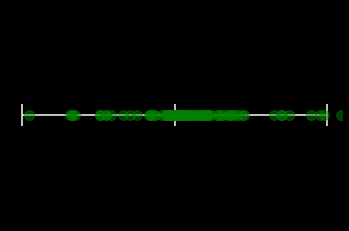

26


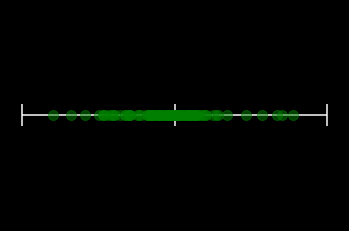

27


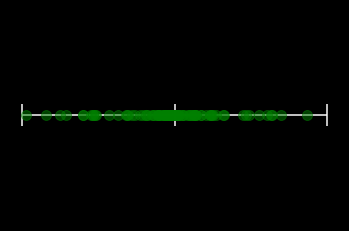

28


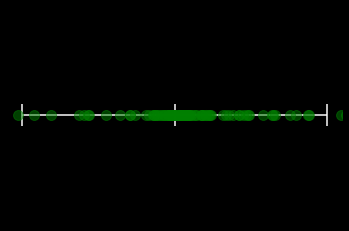

29


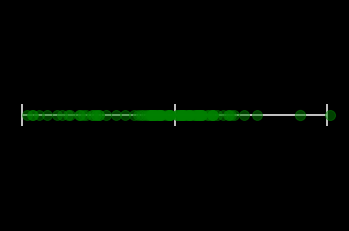

30


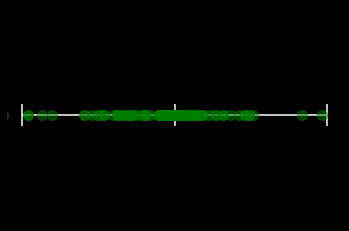

31


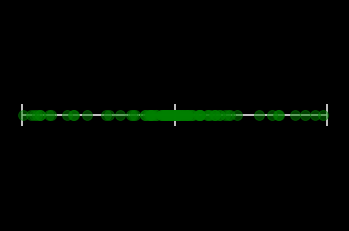

32


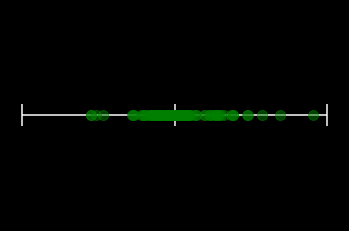

33


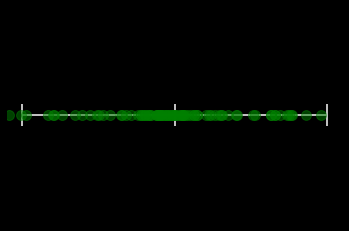

34


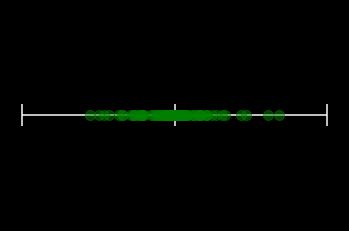

35


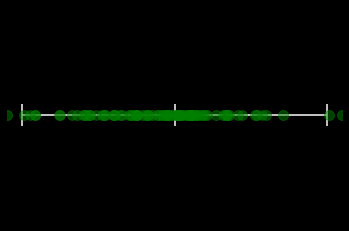

36


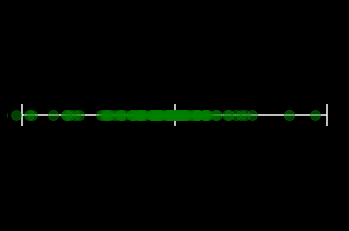

37


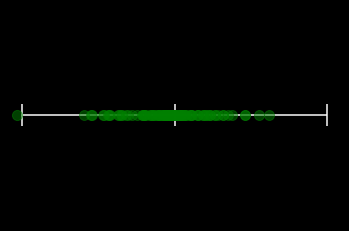

38


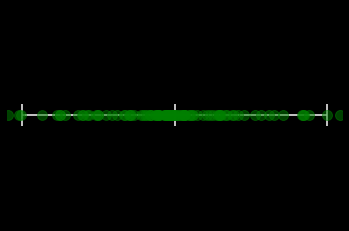

39


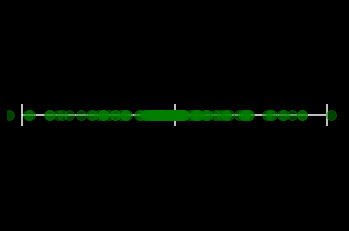

40


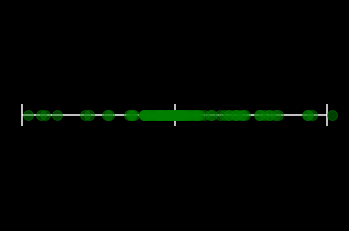

41


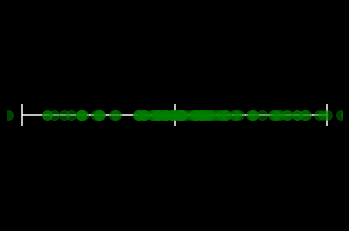

42


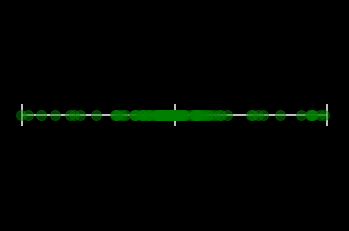

43


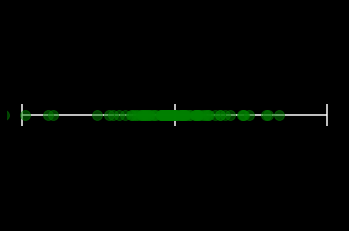

44


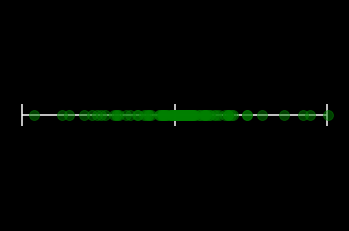

45


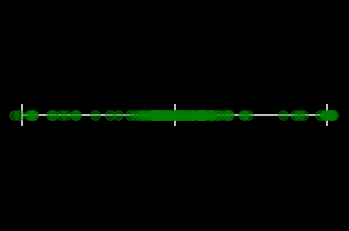

46


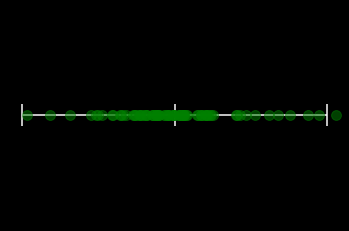

47


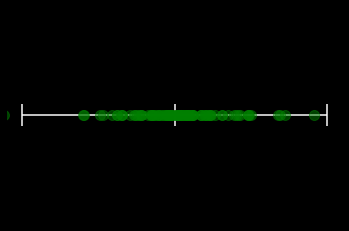

48


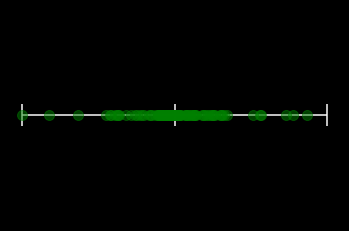

49


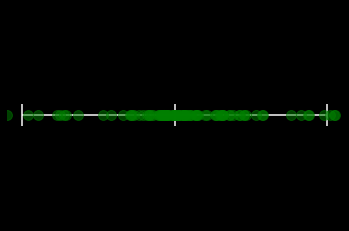

50


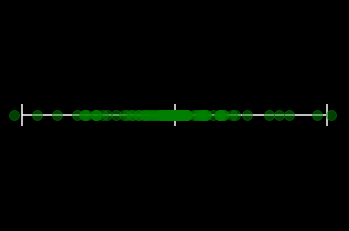

51


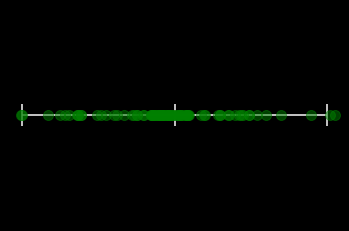

52


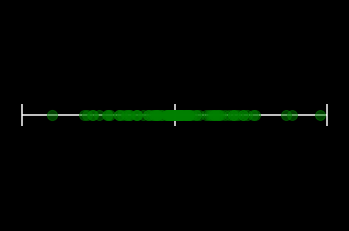

53


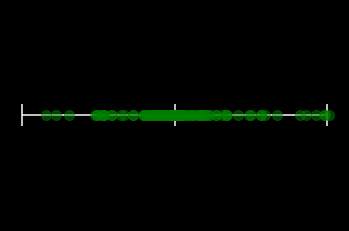

54


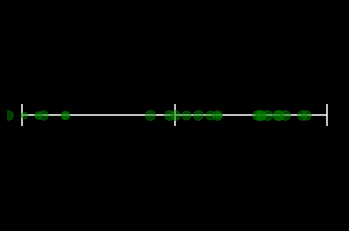

55


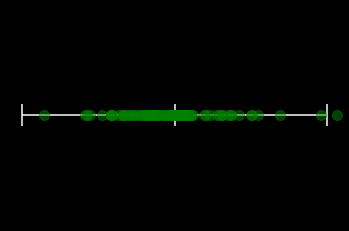

56


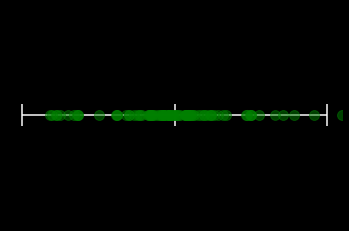

57


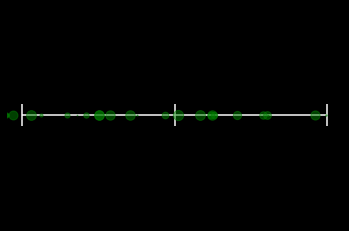

58


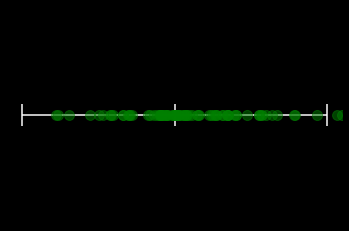

59


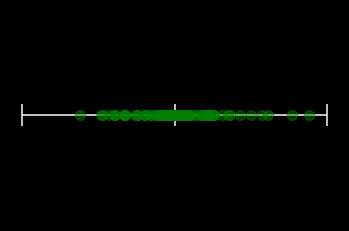

60


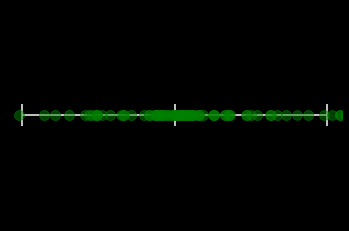

61


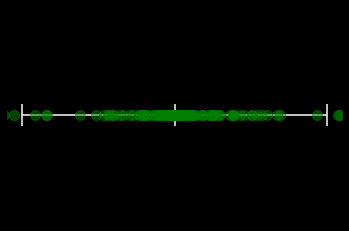

62


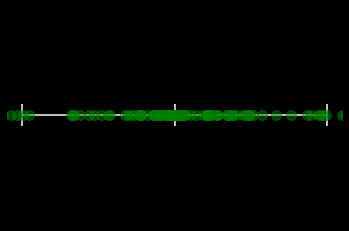

63


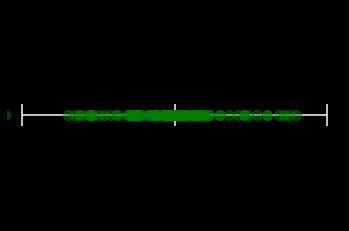

64


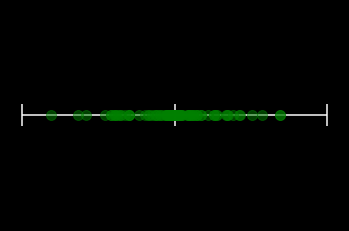

65


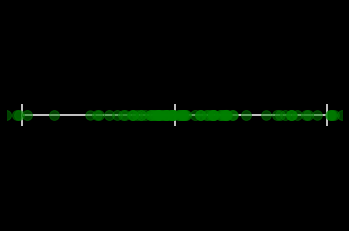

66


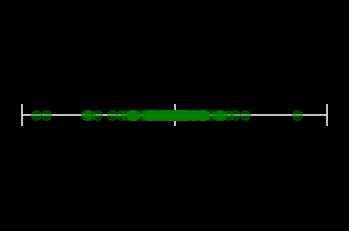

67


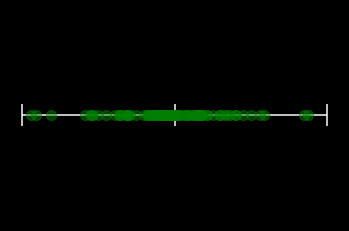

68


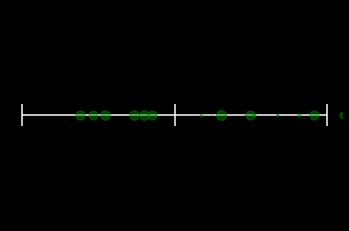

69


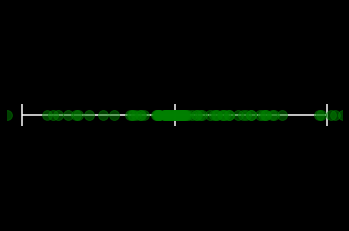

70


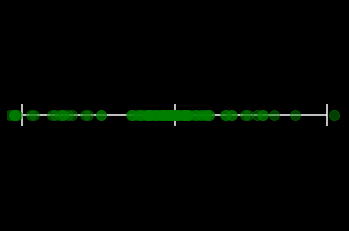

71


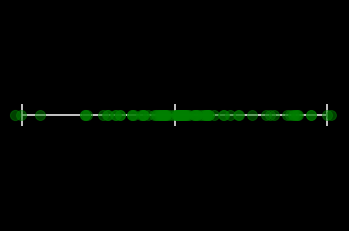

72


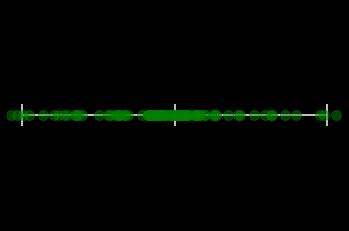

73


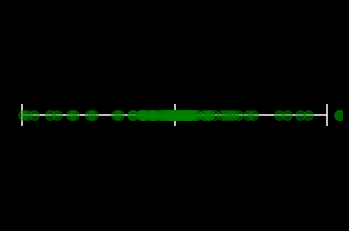

74


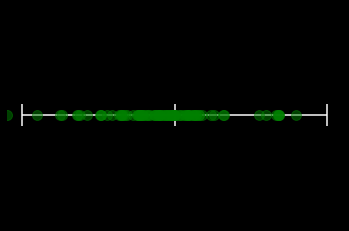

75


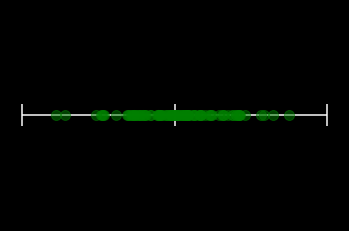

76


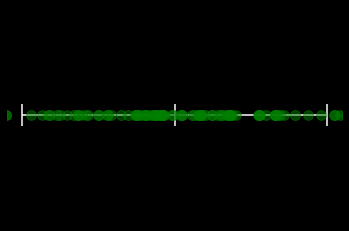

77


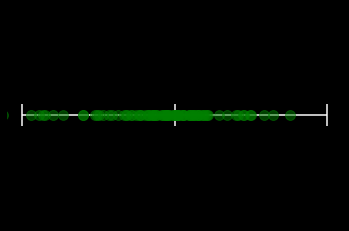

78


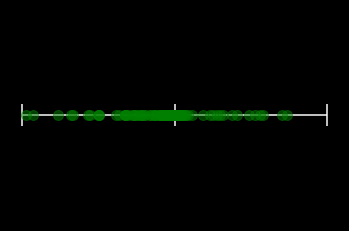

79


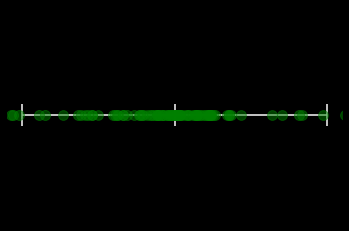

80


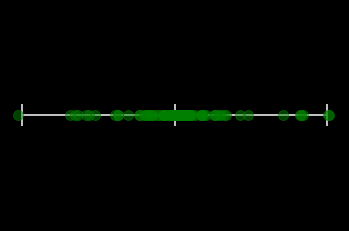

81


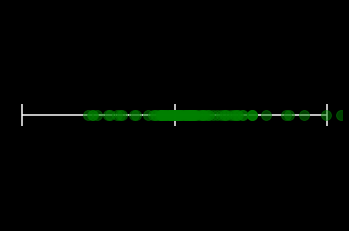

82


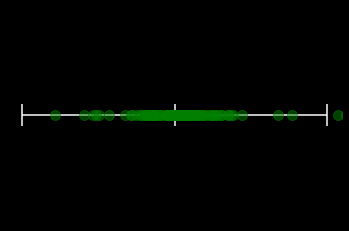

83


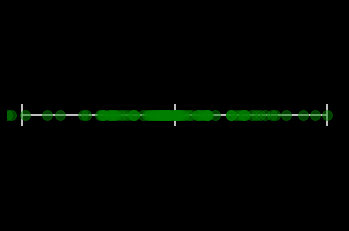

84


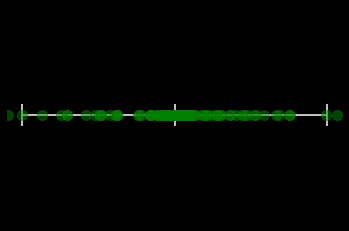

85


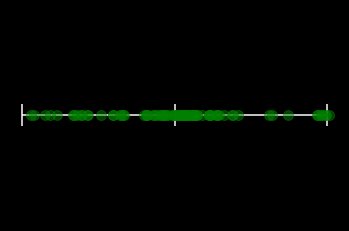

86


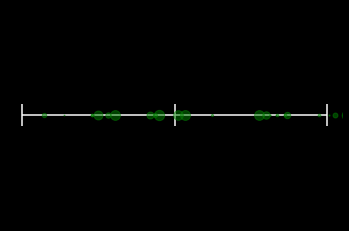

87


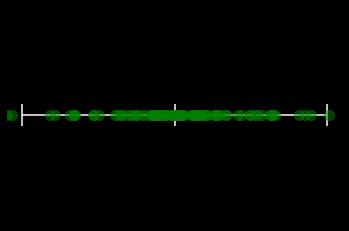

88


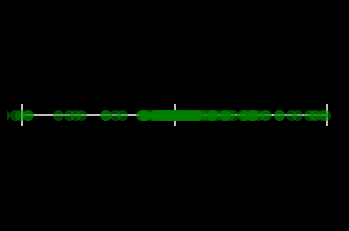

89


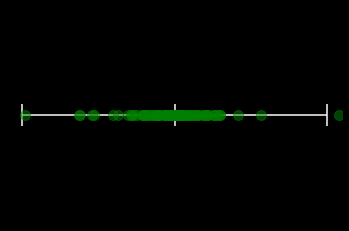

90


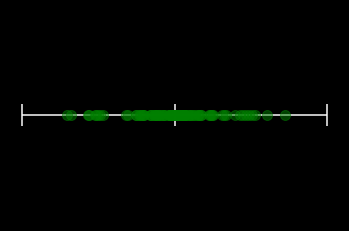

91


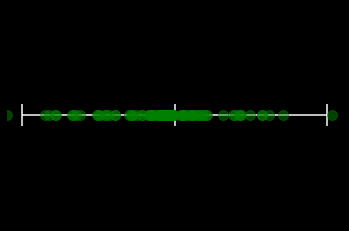

92


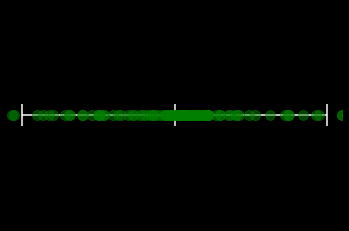

93


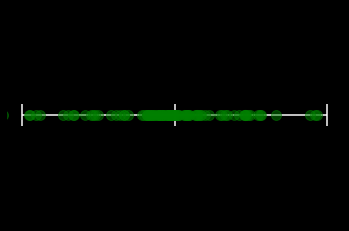

94


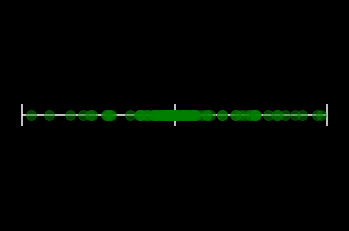

95


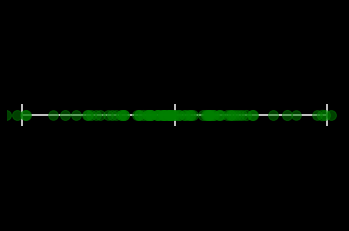

96


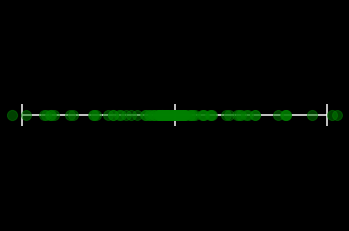

97


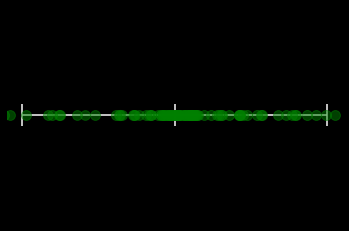

98


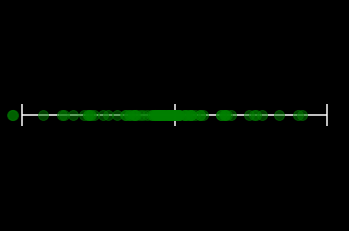

99


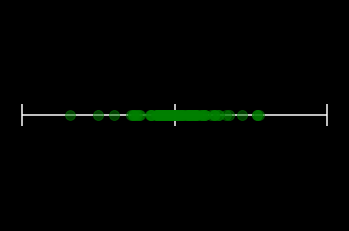

100


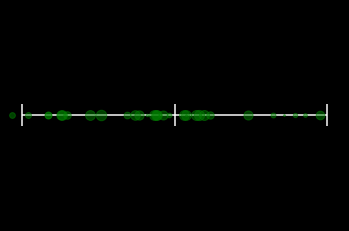

101


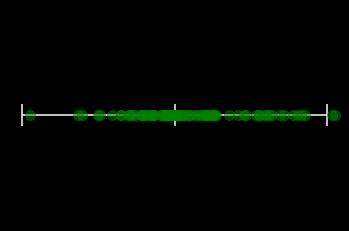

102


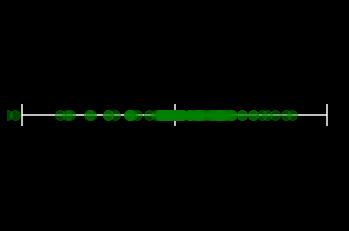

103


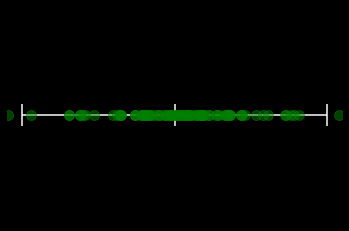

104


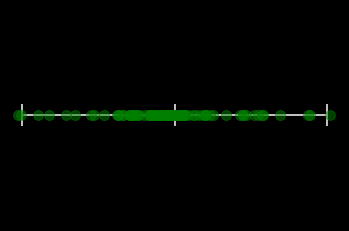

105


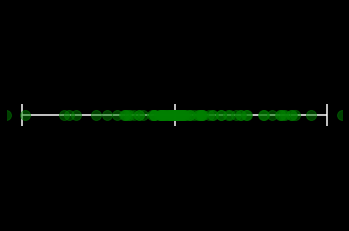

106


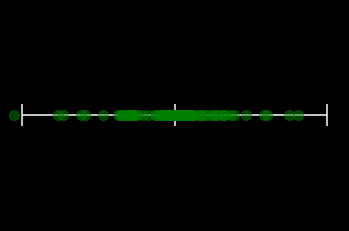

107


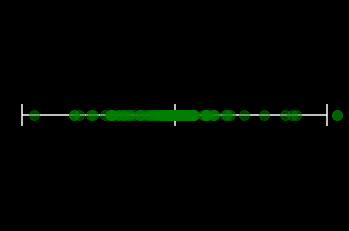

108


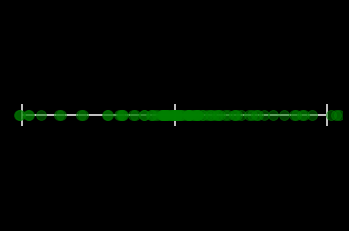

109


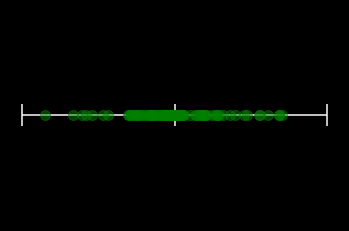

110


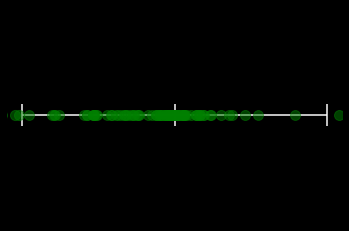

111


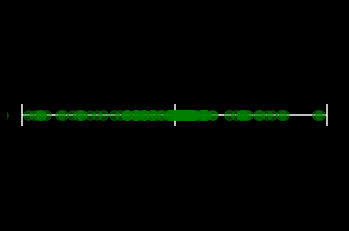

112


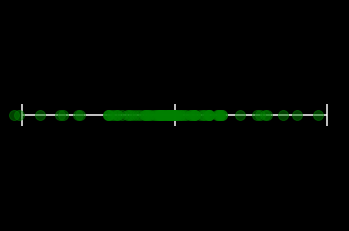

113


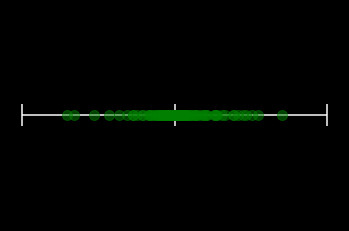

114


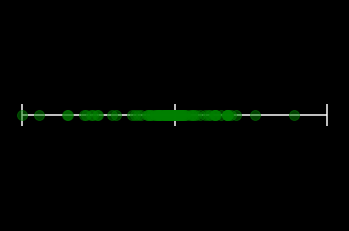

115


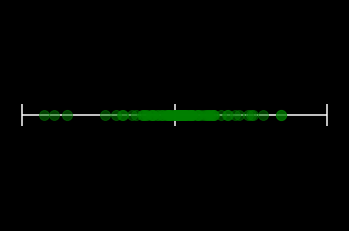

116


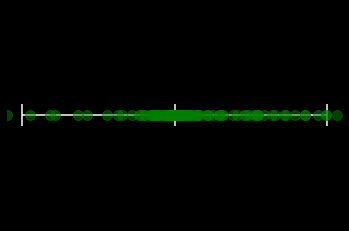

117


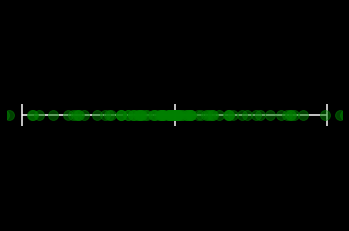

118


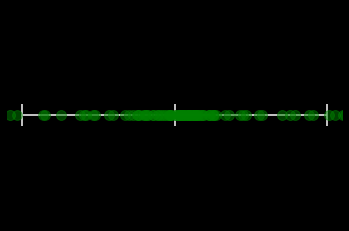

119


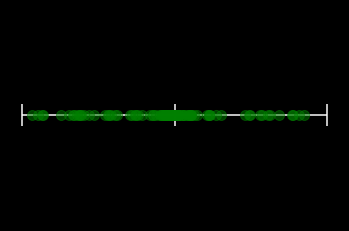

120


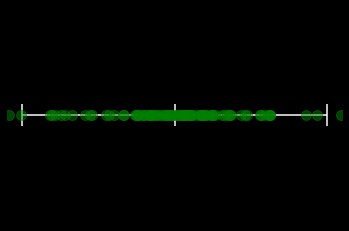

121


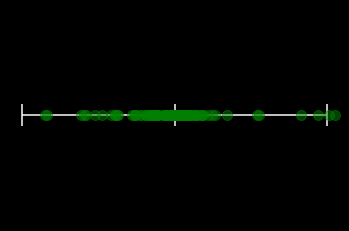

122


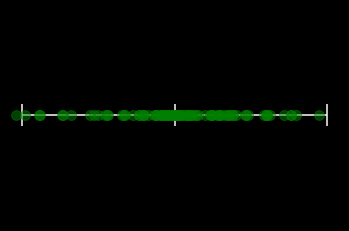

123


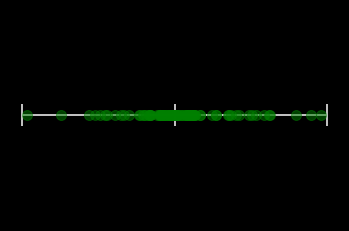

124


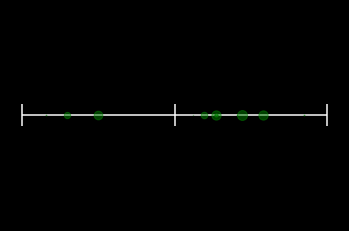

125


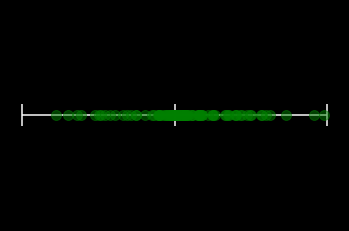

126


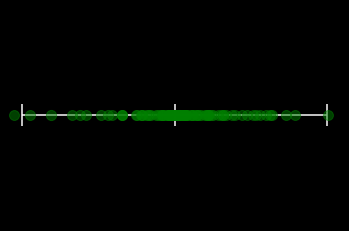

127


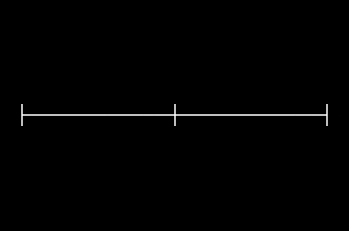

128


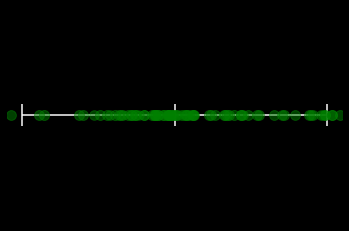

129


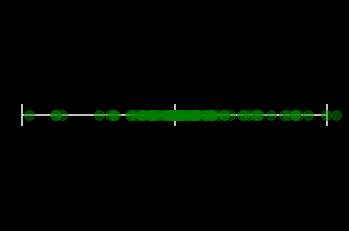

130


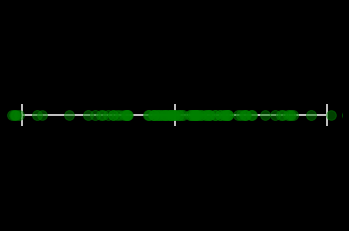

131


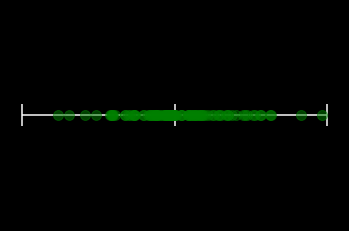

132


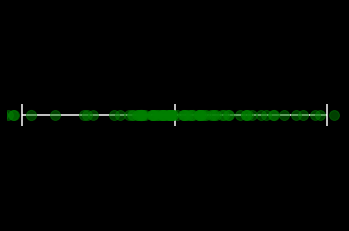

133


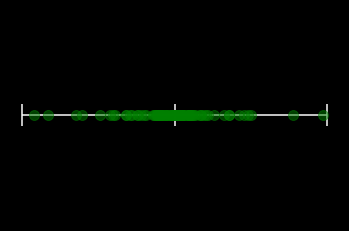

134


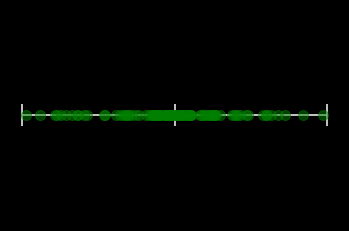

135


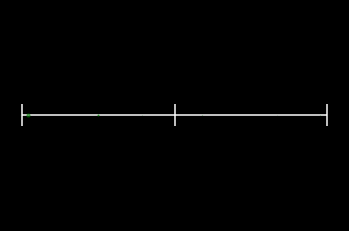

136


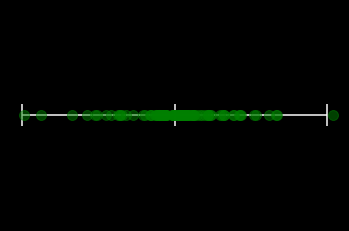

137


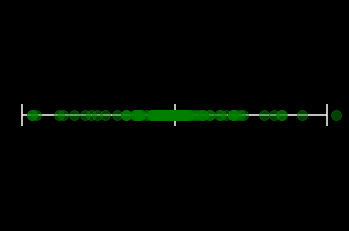

138


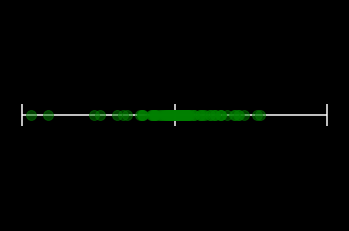

139


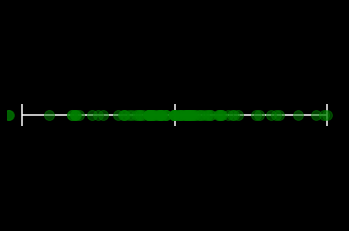

140


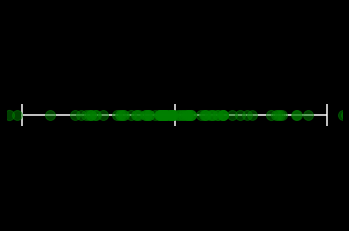

141


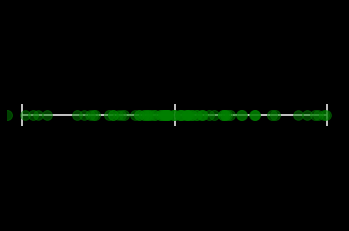

142


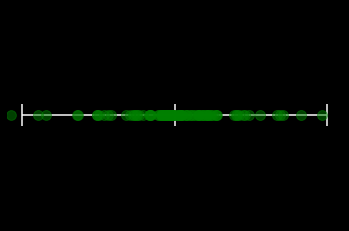

143


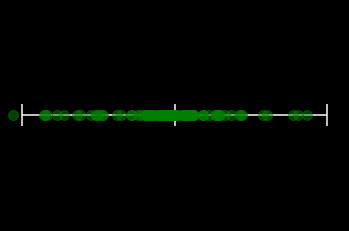

144


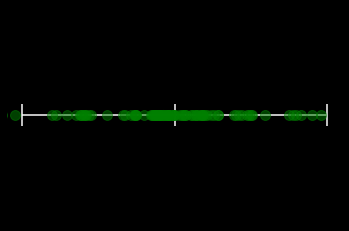

145


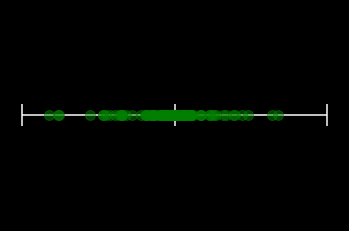

146


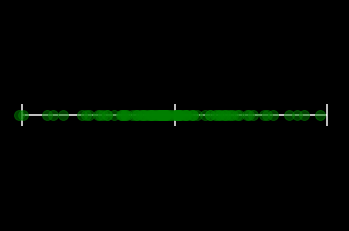

147


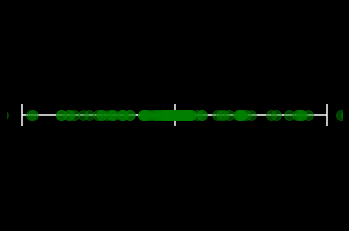

148


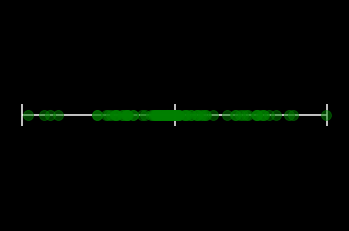

149


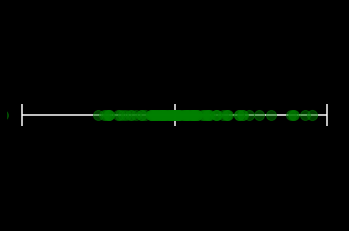

150


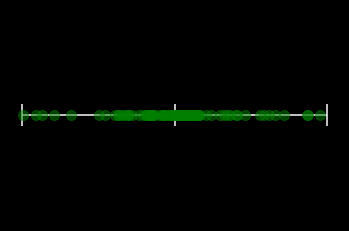

151


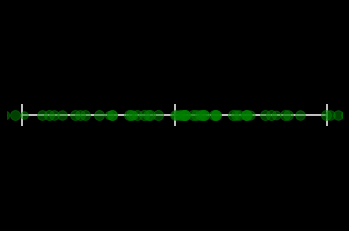

152


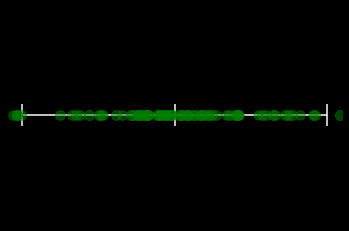

153


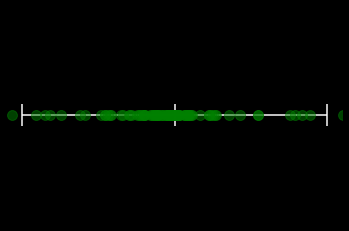

154


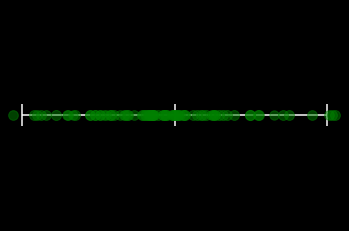

155


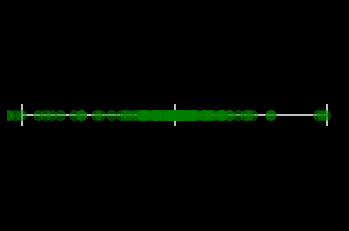

156


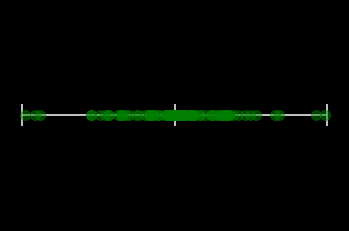

157


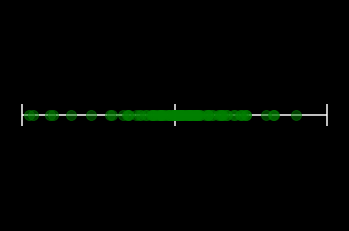

158


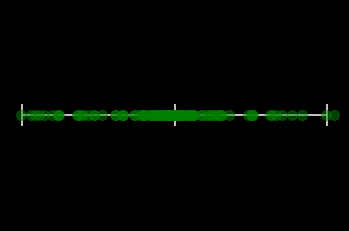

159


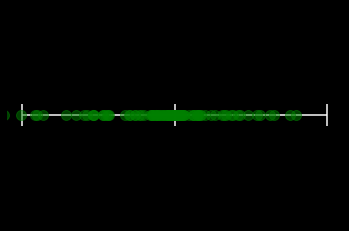

160


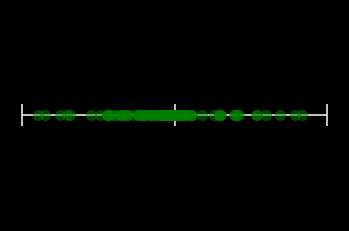

161


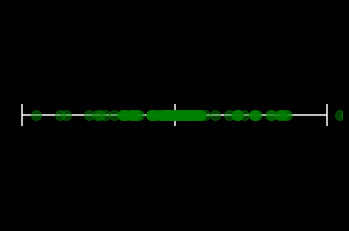

162


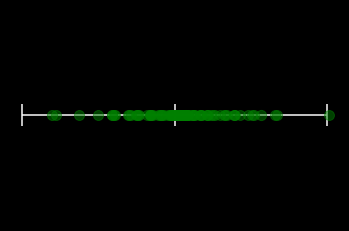

163


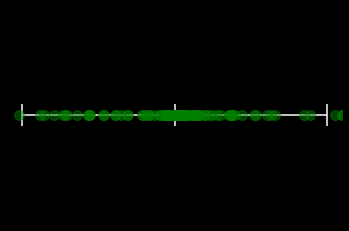

164


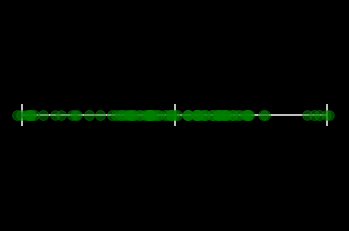

165


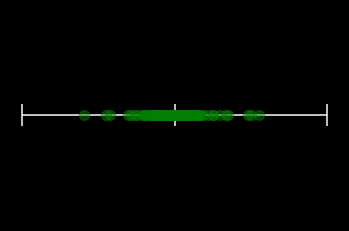

166


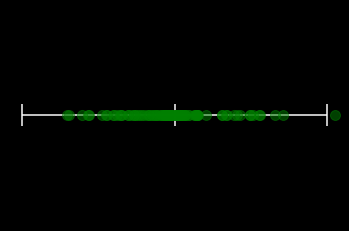

167


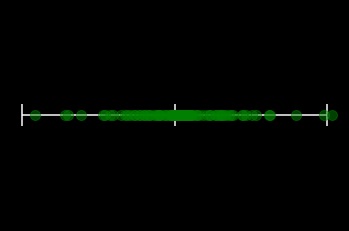

168


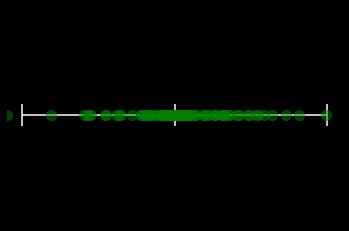

169


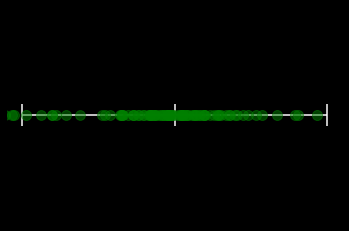

170


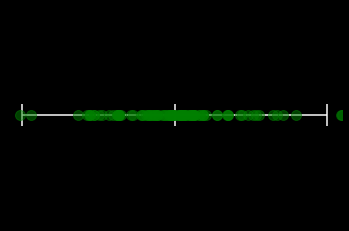

171


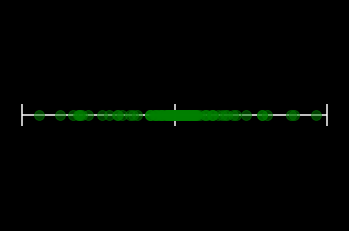

172


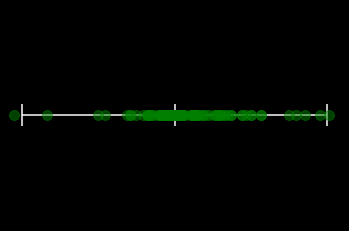

173


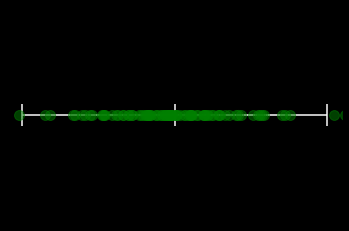

174


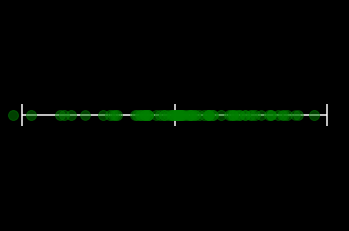

175


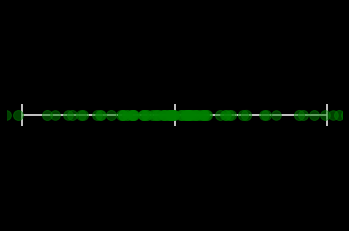

176


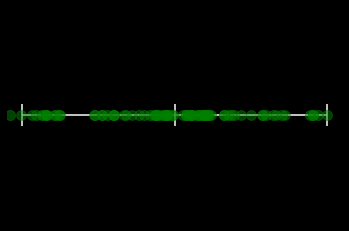

177


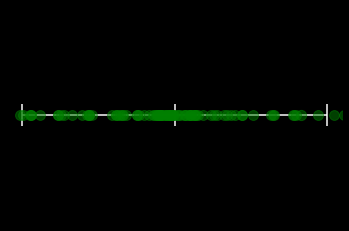

178


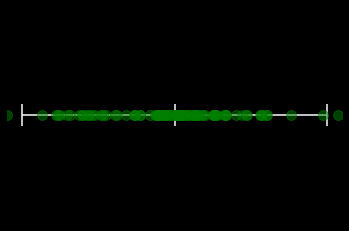

179


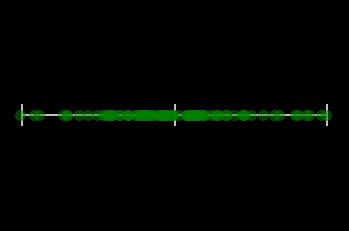

180


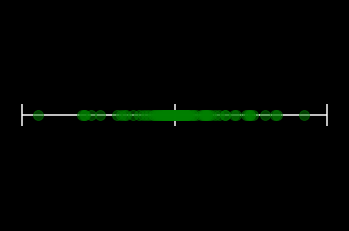

181


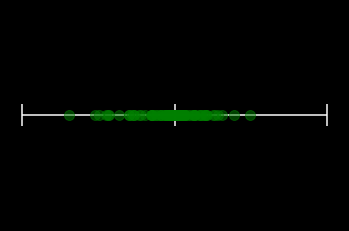

182


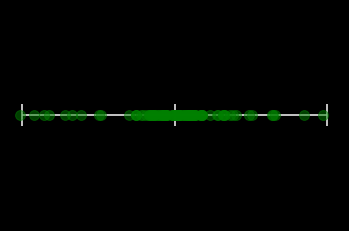

183


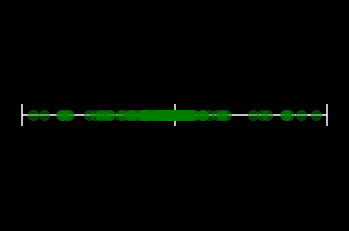

184


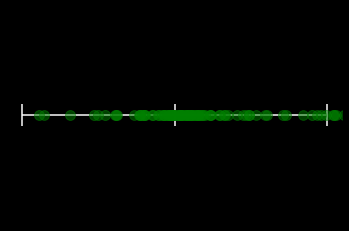

185


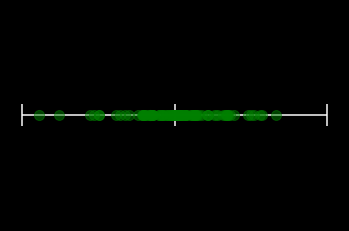

186


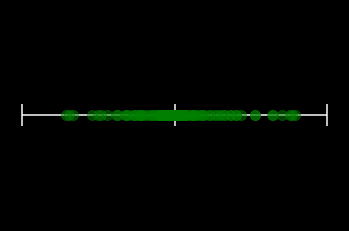

187


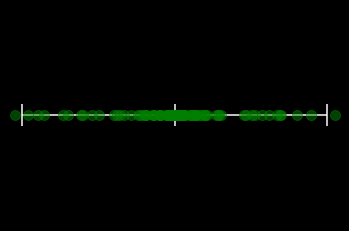

188


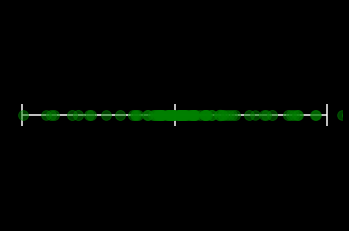

189


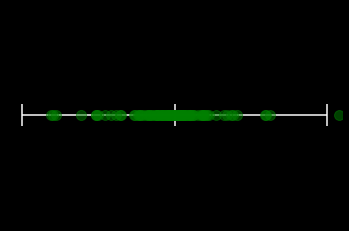

190


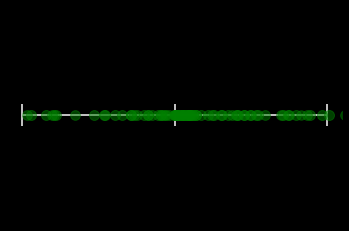

191


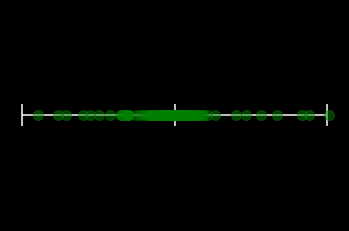

192


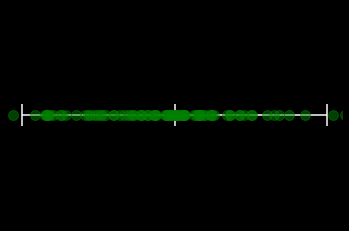

193


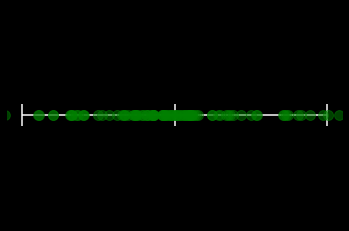

194


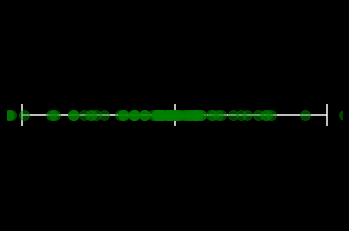

195


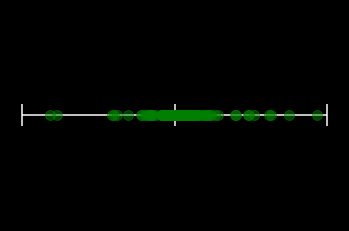

196


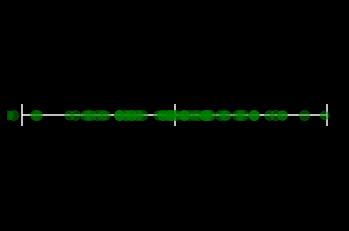

197


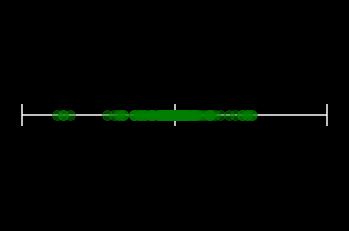

198


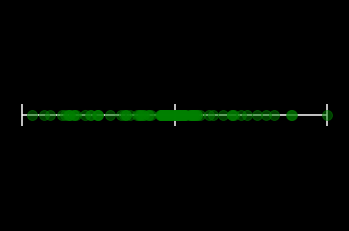

199


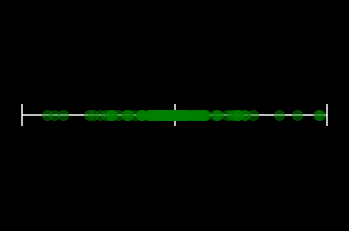

200


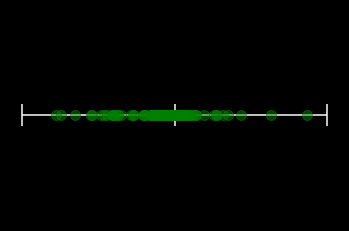

201


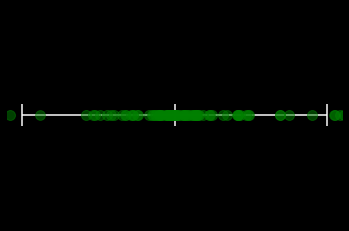

202


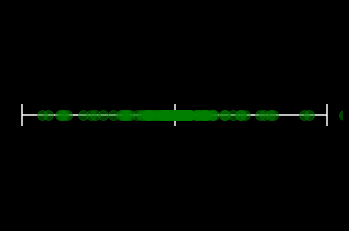

203


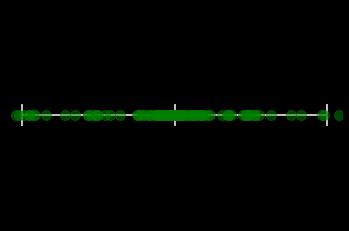

204


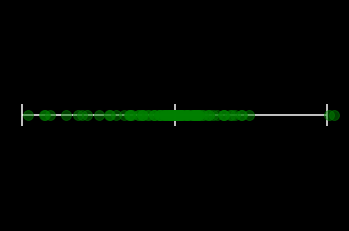

205


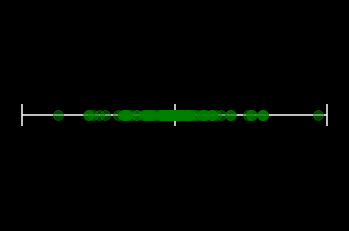

206


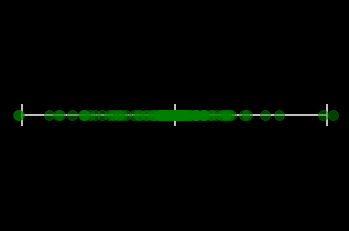

207


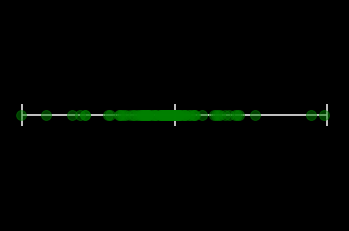

208


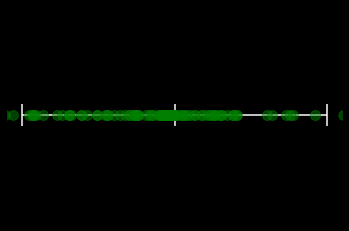

209


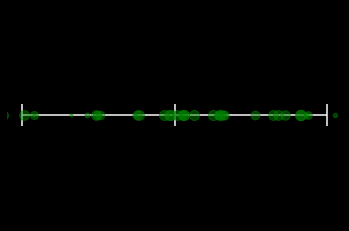

210


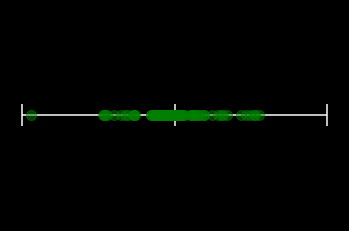

211


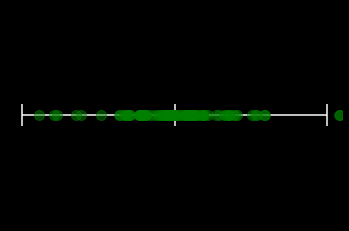

212


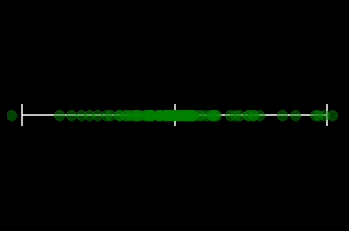

213


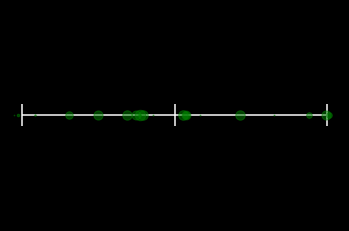

214


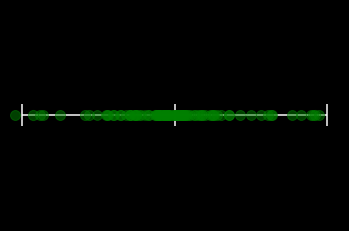

215


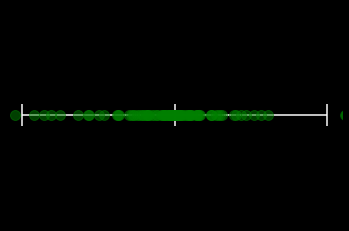

216


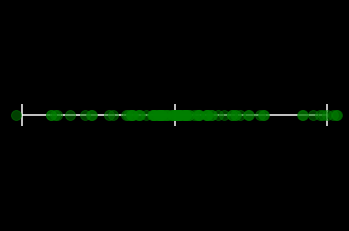

217


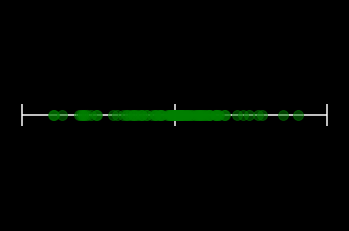

218


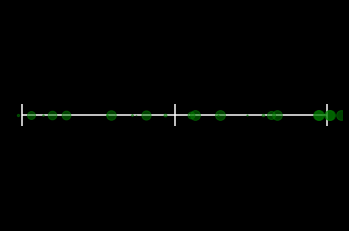

219


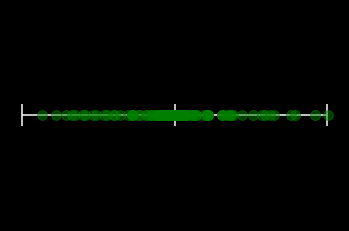

220


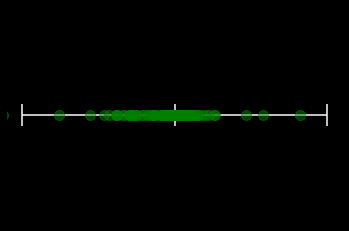

221


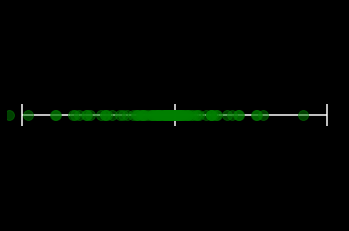

222


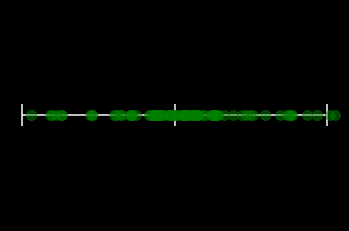

223


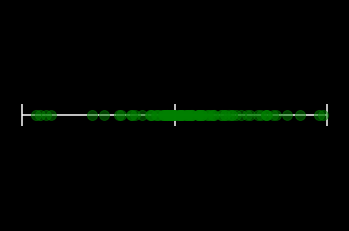

224


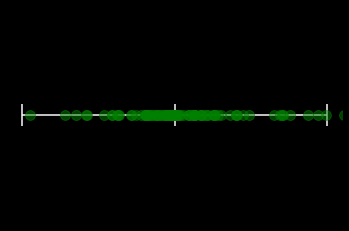

225


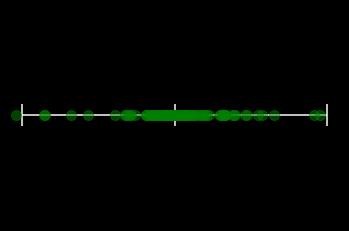

226


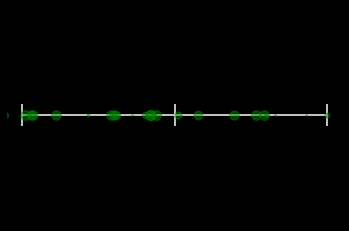

227


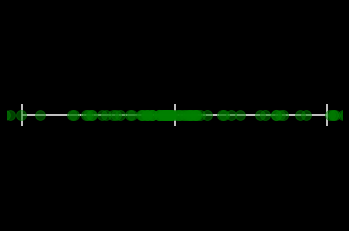

228


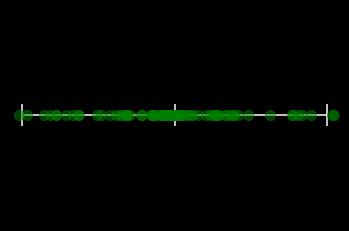

229


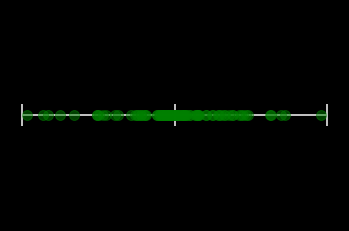

230


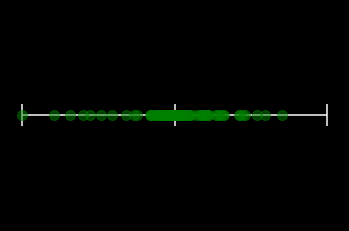

231


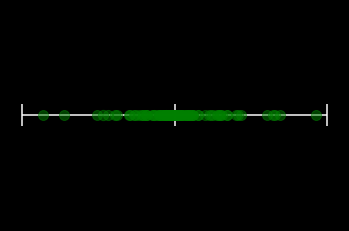

232


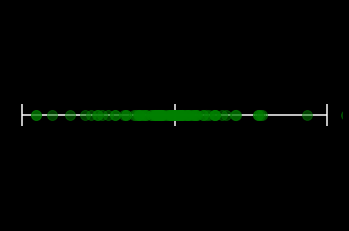

233


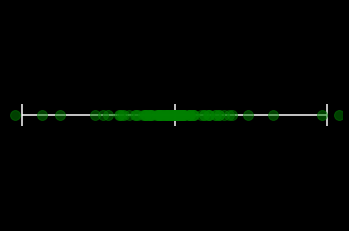

234


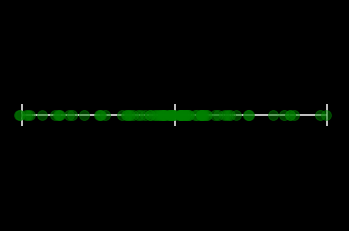

235


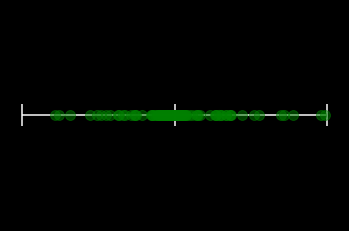

236


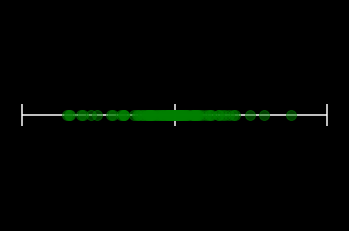

237


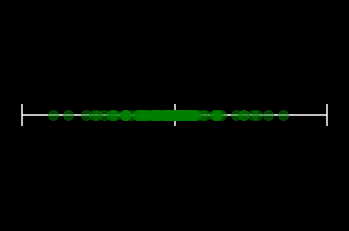

238


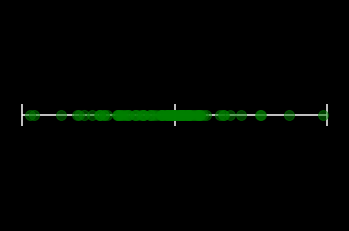

239


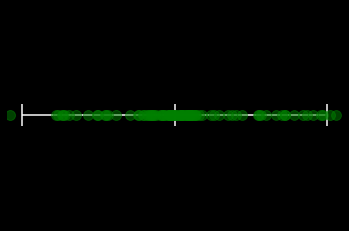

240


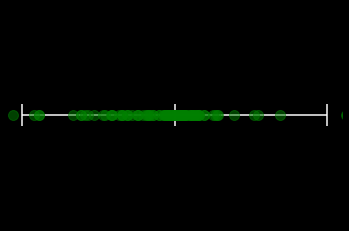

241


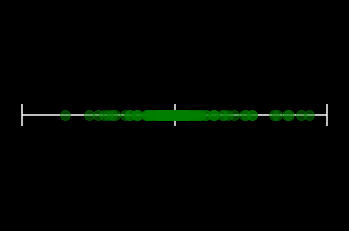

242


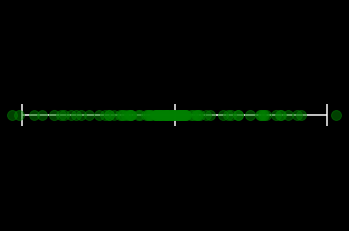

243


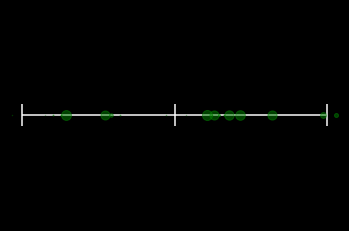

244


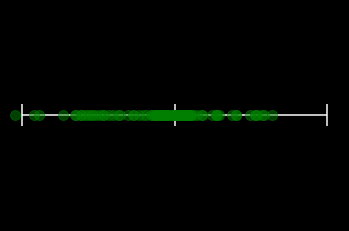

245


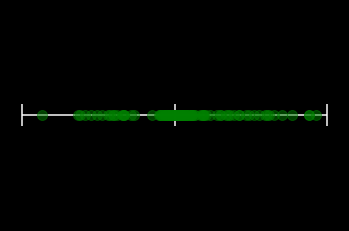

246


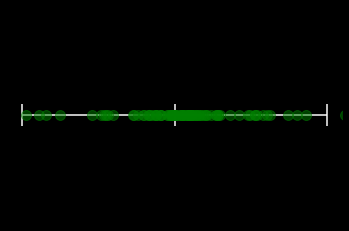

247


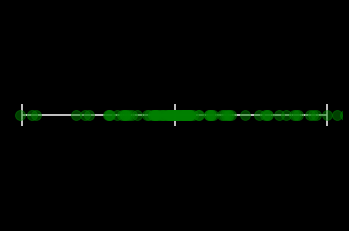

248


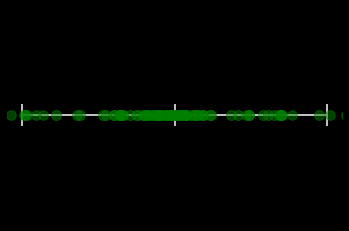

249


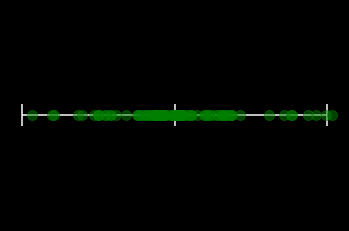

250


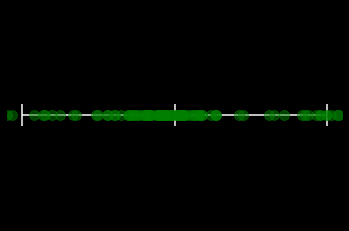

251


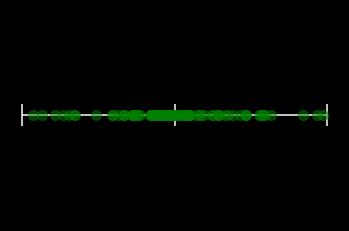

252


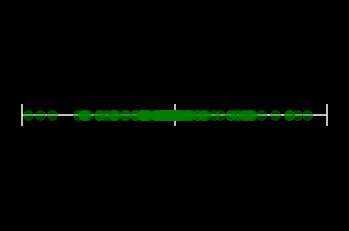

253


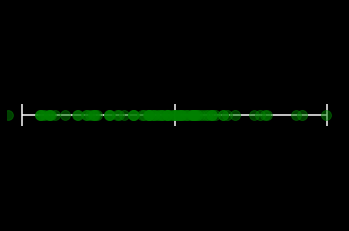

254


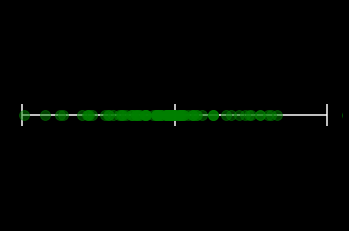

255


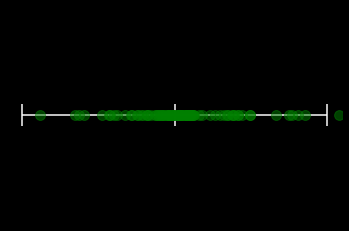

In [30]:
for d in range(mu.shape[1]): #iterate over latent dimensions
    print(d)
    graph(mu[:,d], var[:,d])

Ideas
- Measure "normalness" of the distribution
- What does it mean if the distribution is less centered around 0? More outliers to 1 side, lower/higher stdev, skewness, etc
- Compare shape of dimension's distribution for train vs val set
- How does all this change with different quantities of data
- For betavae: find a dimension corresponding to some underrepresented attribute and see how it differs from one corresponding to a well-represented attribute